# Multi-Vehicle Rendezvous Problem

The dynamics model of an omnidirectional vehicle with friction coefficient
$\alpha$ is defined by the following equation:

$$
m \dot{\textbf{v}} = \textbf{u} - \alpha \textbf{v}
$$

iLQR is applied to a two vehicle system in order to control them to gently
collide with each other with a terminal velocity of $0 \frac{m}{s}$.

The state vector $\textbf{x}$ is defined as follows:
$$\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x_0 & y_0 & x_1 & y_1 & \dot{x}_0 & \dot{y}_0 & \dot{x}_1 & \dot{y}_1
    \end{bmatrix}^T
\end{equation*}$$

The action vector $\textbf{u}$ is defined as follows:
$$\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x_0} & F_{y_0} & F_{x_1} & F_{y_1}
    \end{bmatrix}^T
\end{equation*}$$

**Note**: That since this dynamics model is linear, this problem can be solved
more efficiently with a simple Linear Quadratic Regulator (LQR) instead. This
example is just used to demonstrate how to setup an auto-differentiated
dynamics model.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import numpy as np
import theano.tensor as T
import matplotlib.pyplot as plt

In [4]:
from ilqr import iLQR
from ilqr.cost import QRCost
from ilqr.dynamics import AutoDiffDynamics

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    print("iteration", iteration_count, info, J_opt)

In [6]:
x_inputs = [
    T.dscalar("x_0"),
    T.dscalar("y_0"),
    T.dscalar("x_1"),
    T.dscalar("y_1"),
    T.dscalar("x_0_dot"),
    T.dscalar("y_0_dot"),
    T.dscalar("x_1_dot"),
    T.dscalar("y_1_dot"),
]

u_inputs = [
    T.dscalar("F_x_0"),
    T.dscalar("F_y_0"),
    T.dscalar("F_x_1"),
    T.dscalar("F_y_1"),
]

dt = 0.1  # Discrete time step.
m = 1.0  # Mass.
alpha = 0.1  # Friction coefficient.

# Acceleration.
def acceleration(x_dot, u):
    x_dot_dot = x_dot * (1 - alpha * dt / m) + u * dt / m
    return x_dot_dot

# Discrete dynamics model definition.
f = T.stack([
    x_inputs[0] + x_inputs[4] * dt,
    x_inputs[1] + x_inputs[5] * dt,
    x_inputs[2] + x_inputs[6] * dt,
    x_inputs[3] + x_inputs[7] * dt,
    x_inputs[4] + acceleration(x_inputs[4], u_inputs[0]) * dt,
    x_inputs[5] + acceleration(x_inputs[5], u_inputs[1]) * dt,
    x_inputs[6] + acceleration(x_inputs[6], u_inputs[2]) * dt,
    x_inputs[7] + acceleration(x_inputs[7], u_inputs[3]) * dt,
])

dynamics = AutoDiffDynamics(f, x_inputs, u_inputs)

An instantaneous cost function $l(\textbf{x}_t, \textbf{u}_t)$ is defined as follows:

$$
l(\textbf{x}_t, \textbf{u}_t) = \textbf{x}_t^T Q \textbf{x}_t + \textbf{u}_t^T R \textbf{u}_t
$$

where $Q$ is the state error and $R$ is the control error.

In order to approach the two vehicles to each other, $Q$ is set up to penalize differences in positions as $||\textbf{x}_0 - \textbf{x}_1||^2$ while penalizing non-zero velocities.

In [7]:
Q = np.eye(dynamics.state_size)
Q[0, 2] = Q[2, 0] = -1
Q[1, 3] = Q[3, 1] = -1
R = 0.1 * np.eye(dynamics.action_size)

cost = QRCost(Q, R)

The vehicles are initialized at $(0, 0)$ and $(10, 10)$ with velocities $(0, -5)$ and $(5, 0)$ respectively.

In [9]:
N = 1000  # Number of time steps in trajectory.
x0 = np.array([0, 0, 10, 10, 0, -5, 5, 0])  # Initial state.

# Random initial action path.
us_init = np.random.uniform(-1, 1, (N, dynamics.action_size))

In [10]:
J_hist = []
ilqr = iLQR(dynamics, cost, N)
xs, us = ilqr.fit(x0, us_init, on_iteration=on_iteration)

iteration 0 accepted 6.788751152153822e+80
iteration 1 accepted 3.1241389968001413e+76
iteration 2 accepted 1.0430318391738698e+71
iteration 3 accepted 5.871201943152709e+63
iteration 4 accepted 1.3431401685733845e+54
iteration 5 accepted 3.0659406488592522e+41
iteration 6 accepted 188422314693.2443
iteration 7 accepted 23370.775337989027
iteration 8 failed 23370.775337989027
iteration 9 failed 23370.775337989027
iteration 10 failed 23370.775337989027
iteration 11 failed 23370.775337989027
iteration 12 failed 23370.775337989027
iteration 13 failed 23370.775337989027
iteration 14 failed 23370.775337989027
iteration 15 converged 23370.775337989016


In [11]:
x_0 = xs[:, 0]
y_0 = xs[:, 1]
x_1 = xs[:, 2]
y_1 = xs[:, 3]
x_0_dot = xs[:, 4]
y_0_dot = xs[:, 5]
x_1_dot = xs[:, 6]
y_1_dot = xs[:, 7]

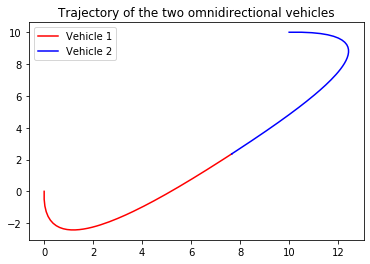

In [12]:
_ = plt.title("Trajectory of the two omnidirectional vehicles")
_ = plt.plot(x_0, y_0, "r")
_ = plt.plot(x_1, y_1, "b")
_ = plt.legend(["Vehicle 1", "Vehicle 2"])

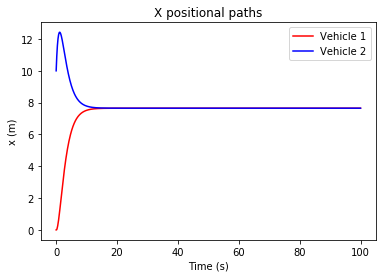

In [13]:
t = np.arange(N + 1) * dt
_ = plt.plot(t, x_0, "r")
_ = plt.plot(t, x_1, "b")
_ = plt.xlabel("Time (s)")
_ = plt.ylabel("x (m)")
_ = plt.title("X positional paths")
_ = plt.legend(["Vehicle 1", "Vehicle 2"])

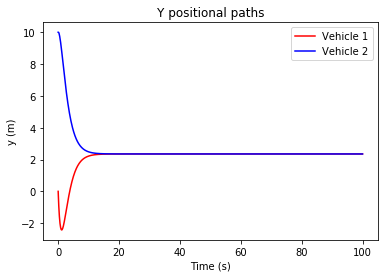

In [14]:
_ = plt.plot(t, y_0, "r")
_ = plt.plot(t, y_1, "b")
_ = plt.xlabel("Time (s)")
_ = plt.ylabel("y (m)")
_ = plt.title("Y positional paths")
_ = plt.legend(["Vehicle 1", "Vehicle 2"])

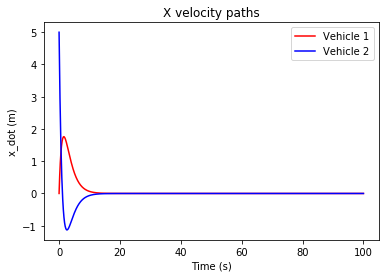

In [15]:
_ = plt.plot(t, x_0_dot, "r")
_ = plt.plot(t, x_1_dot, "b")
_ = plt.xlabel("Time (s)")
_ = plt.ylabel("x_dot (m)")
_ = plt.title("X velocity paths")
_ = plt.legend(["Vehicle 1", "Vehicle 2"])

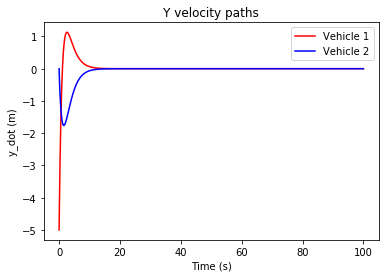

In [16]:
_ = plt.plot(t, y_0_dot, "r")
_ = plt.plot(t, y_1_dot, "b")
_ = plt.xlabel("Time (s)")
_ = plt.ylabel("y_dot (m)")
_ = plt.title("Y velocity paths")
_ = plt.legend(["Vehicle 1", "Vehicle 2"])

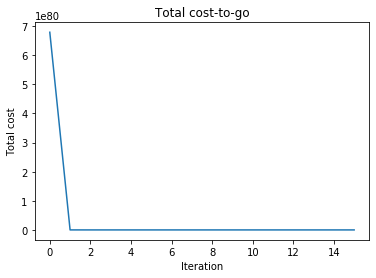

In [17]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")